In [ ]:
!pip install fingerprint_enhancer
import fingerprint_enhancer
# !pip install fingerprint-feature-extractor
# import fingerprint_feature_extractor
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from skimage.morphology import skeletonize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fingerprint-enhancer: filename=fingerprint_enhancer-0.0.12-py3-none-any.whl size=8059 sha256=62f40f07489cc885479574baf6f7c9ada2770841be1e85d3a7531cc9fb6169ac
  Stored in directory: /root/.cache/pip/wheels/c1/10/92/54ee2fcda0ca17304e47e2bc2e20542a6c92fbfc668c6aeba7
Successfully built fingerprint-enhancer


In [ ]:
def filter_mask(img):
  # Calculate the local gradient (using Sobel filters)
  gx, gy = cv.Sobel(img, cv.CV_32F, 1, 0), cv.Sobel(img, cv.CV_32F, 0, 1)
  # Calculate the magnitude of the gradient for each pixel
  gx2, gy2 = gx**2, gy**2
  gm = np.sqrt(gx2 + gy2)
  # Integral over a square window
  sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
  # Use a simple threshold for segmenting the fingerprint pattern
  thr = sum_gm.max() * 0.2
  mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
  # A 1-pixel background border is added to the mask before computing the distance transform
  mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
  return mask_distance

In [ ]:
def enhancer(img):
  enhanced = fingerprint_enhancer.enhance_Fingerprint(img)		# enhance the fingerprint image
  # plt.imshow(enhanced)
  return enhanced

In [ ]:
def convert_to_3d(img):
  res=np.empty([img.shape[0],img.shape[1],3])
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j]==0:
        res[i,j]=[255,255,255]
      else:
        res[i,j]=[0,0,0]
  # plt.imshow(res)
  return res

In [ ]:
def binarize(img):
  _,bin = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
  # plt.imshow(cv.cvtColor(res, cv.COLOR_RGB2BGR))
  return bin

In [ ]:
def skeletonize(img):
  skeleton = cv.ximgproc.thinning(img, thinningType = cv.ximgproc.THINNING_GUOHALL)
  # plt.imshow(cv.cvtColor(skeleton, cv.COLOR_RGB2BGR))
  return skeleton

In [ ]:
# FeaturesTerminations, FeaturesBifurcations = fingerprint_feature_extractor.extract_minutiae_features(out, spuriousMinutiaeThresh=10, invertImage=False, showResult=True, saveResult=True)

# Minutiae detection

In [ ]:
# Utility function to draw a set of minutiae over an image
def draw_minutiae(fingerprint, minutiae, termination_color = (255,0,0), bifurcation_color = (0,0,255)):
    res = cv.cvtColor(fingerprint, cv.COLOR_GRAY2BGR)
    
    for x, y, t, *d in minutiae:
        color = termination_color if t else bifurcation_color
        if len(d)==0:
            cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 5)
        # else:
        #     cv.drawMarker(res, (x,y), color, cv.MARKER_CROSS, 1)
        else:
            d = d[0]
            ox = int(round(math.cos(d) * 3))
            oy = int(round(math.sin(d) * 3))
            cv.circle(res, (x,y), 2, color, 3, cv.LINE_AA)
            cv.line(res, (x,y), (x+ox,y-oy), color, 3, cv.LINE_AA)        
    return res

In [ ]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

In [ ]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                    ])
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)
def minutiae_generator(skeleton):
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  # Apply the lookup table to obtain the crossing number of each pixel
  cn = cv.LUT(cn_values, cn_lut)
  # Keep only crossing numbers on the skeleton
  cn[skeleton==0] = 0

  # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
  minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

  return minutiae

# Orientation of minutiae points

In [ ]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

In [ ]:
import math
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

In [ ]:
def follow_ridge_and_compute_angle(x, y,cn_values,skeleton, d = 8):
    px, py = x, y
    length = 0.0
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

In [ ]:
# Utilities for angle arithmetics
def angle_abs_difference(a, b):
    return math.pi - abs(abs(a - b) - math.pi)

def angle_mean(a, b):
    return math.atan2((math.sin(a)+math.sin(b))/2, ((math.cos(a)+math.cos(b))/2))

In [ ]:
def minutiae_angles(minutiae, skeleton):
  minutiae_angle = []
  # Skeleton: from 0/255 to 0/1 values
  skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
  # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
  cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
  for x, y, term in minutiae:
      d = None
      if term: # termination: simply follow and compute the direction        
          d = follow_ridge_and_compute_angle(x, y, cn_values, skeleton)
      else: # bifurcation: follow each of the three branches
          dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
          if len(dirs)==3: # only if there are exactly three branches
              angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1],cn_values,skeleton, d) for d in dirs]
              if all(a is not None for a in angles):
                  a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                  d = angle_mean(a1, a2)                
      if d is not None:
          minutiae_angle.append( (x, y, term, d) )
  return minutiae_angle

# Singularity Points detection

In [ ]:
signum = lambda x: -1 if x < 0 else 1

cells = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

def get_angle(left, right):
    angle = left - right
    if abs(angle) > 180:
        angle = -1 * signum(angle) * (360 - abs(angle))
    return angle

    
def poincare_index_at(i, j, angles, tolerance):
    deg_angles = [math.degrees(angles[i - k][j - l]) % 180 for k, l in cells]
    index = 0
    for k in range(0, 8):
        if abs(get_angle(deg_angles[k], deg_angles[k + 1])) > 90:
            deg_angles[k + 1] += 180
        index += get_angle(deg_angles[k], deg_angles[k + 1])

    if 180 - tolerance <= index and index <= 180 + tolerance:
        return "loop"
    if -180 - tolerance <= index and index <= -180 + tolerance:
        return "delta"
    if 360 - tolerance <= index and index <= 360 + tolerance:
        return "whorl"
    return "none"

In [ ]:
def calculate_singularities(im, angles, tolerance, W):
    (x, y) = im.size
    result = im.convert("RGB")

    draw = ImageDraw.Draw(result)

    colors = {"loop" : (150, 0, 0), "delta" : (0, 150, 0), "whorl": (0, 0, 150)}

    for i in range(1, len(angles) - 1):
        for j in range(1, len(angles[i]) - 1):
            singularity = poincare_index_at(i, j, angles, tolerance)
            if singularity != "none":
                draw.ellipse([(i * W, j * W), ((i + 1) * W, (j + 1) * W)], outline = colors[singularity])

    del draw

    return result

# Core and Delta Points Detection

In [ ]:
import numpy as np;
import cv2;
from scipy import ndimage;
from scipy import signal

def ridge_orient(im, gradientsigma, blocksigma, orientsmoothsigma):
    rows,cols = im.shape;
    #Calculate image gradients.
    sze = np.fix(6*gradientsigma);
    if np.remainder(sze,2) == 0:
        sze = sze+1;
        
    gauss = cv2.getGaussianKernel(np.int(sze),gradientsigma);
    f = gauss * gauss.T;
    
    fy,fx = np.gradient(f);     #Gradient of Gaussian
    
    #Gx = ndimage.convolve(np.double(im),fx);
    #Gy = ndimage.convolve(np.double(im),fy);
    
    Gx = signal.convolve2d(im,fx,mode='same');    
    Gy = signal.convolve2d(im,fy,mode='same');
    
    Gxx = np.power(Gx,2);
    Gyy = np.power(Gy,2);
    Gxy = Gx*Gy;
    
    #Now smooth the covariance data to perform a weighted summation of the data.    
    
    sze = np.fix(6*blocksigma);
    
    gauss = cv2.getGaussianKernel(np.int(sze),blocksigma);
    f = gauss * gauss.T;
    
    Gxx = ndimage.convolve(Gxx,f);
    Gyy = ndimage.convolve(Gyy,f);
    Gxy = 2*ndimage.convolve(Gxy,f);
    
    # Analytic solution of principal direction
    denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps;
    
    sin2theta = Gxy/denom;            # Sine and cosine of doubled angles
    cos2theta = (Gxx-Gyy)/denom;
    
    
    if orientsmoothsigma:
        sze = np.fix(6*orientsmoothsigma);
        if np.remainder(sze,2) == 0:
            sze = sze+1;    
        gauss = cv2.getGaussianKernel(np.int(sze),orientsmoothsigma);
        f = gauss * gauss.T;
        cos2theta = ndimage.convolve(cos2theta,f); # Smoothed sine and cosine of
        sin2theta = ndimage.convolve(sin2theta,f); # doubled angles
    
    orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2;
    return(orientim);

In [ ]:
import numpy as np

def normalise(img,mean,std):
    normed = (img - np.mean(img))/(np.std(img));    
    return(normed)
    
def ridge_segment(im,blksze,thresh):
    
    rows,cols = im.shape;    
    
    im = normalise(im,0,1);    # normalise to get zero mean and unit standard deviation
    
    
    new_rows =  np.int(blksze * np.ceil((np.float(rows))/(np.float(blksze))))
    new_cols =  np.int(blksze * np.ceil((np.float(cols))/(np.float(blksze))))
    
    padded_img = np.zeros((new_rows,new_cols));
    stddevim = np.zeros((new_rows,new_cols));
    
    padded_img[0:rows][:,0:cols] = im;
    
    for i in range(0,new_rows,blksze):
        for j in range(0,new_cols,blksze):
            block = padded_img[i:i+blksze][:,j:j+blksze];
            
            stddevim[i:i+blksze][:,j:j+blksze] = np.std(block)*np.ones(block.shape)
    
    stddevim = stddevim[0:rows][:,0:cols]
                    
    mask = stddevim > thresh;
    
    mean_val = np.mean(im[mask]);
    
    std_val = np.std(im[mask]);
    
    normim = (im - mean_val)/(std_val);
    
    return(normim,mask)

In [ ]:
import numpy as np
import numpy.matlib



def walkonce(im, mask, dfim, start, step, Td):
	sp = []
	current =0
	path = np.array([start])
	while True:
		temp = path[current,:]
		ori = dfim[int(temp[0]), int(temp[1])]
		current = current + 1
		path = np.concatenate([path, temp + step*(np.around([[-np.sin(ori), np.cos(ori)]]))], axis=0)
		if (any(path[current,:] < 1) or any((path[current,:] - im.shape) > 0) or not mask[int(path[current,0]),int(path[current,1])]):
			break
		cpath = path[0:current,:]
		dcpath = cpath - np.matmul(np.ones((cpath.shape[0],1)), np.array([path[current,:]]))
		sqart = np.sqrt(dcpath[:,0]**2 + dcpath[:,1]**2)
		sqart = np.transpose(sqart).reshape((1,-1))
		sqart = np.fliplr(sqart)
		indx = np.argwhere(sqart < Td)
		if min(indx.shape)==0:
			ind = np.empty(shape=(0,0))
		else:
			ind = sqart.shape[1] - indx[0][1]
		if ind.size !=0:
			if current == ind:
				sp = path[current,:]
			elif (current - ind) <=11:
				sp =  np.around(np.sum(path[ind:current+1,:], axis=0)/(current - ind + 1))
			break
	return sp

def checkstable(im, mask, orientim, tempsp, step, Td, R):
	stable=0
	tempsp = np.array([tempsp])
	
	if min(tempsp.shape) !=0:
		stable=1
		trystart = np.matmul(np.ones((4,1)), tempsp) + np.array([[0,-1], [-1,0], [0,1], [1,0]])*R
		for j in range(0,4):
			if (any(trystart[j,:] < 1) or any((trystart[j,:] - im.shape) > 0) or not mask[int(trystart[j,0]),int(trystart[j,1])]):
				stable=0
				break
			newsp = walkonce(im, mask, orientim, trystart[j,:], step, Td)
			newsp = np.array([newsp])
			if min(newsp.shape) == 0 or np.linalg.norm(tempsp - newsp) > R:
				stable=0
				break
	return stable


def mergeneighbors(points, threshold):

	for i in range(0,points.shape[0]-1):
		if points[i,0] == 0:
			continue
		pointi = points[i,:]
		for j in range(i+1,points.shape[0]):
			if points[j,0] == 0:
				continue
			if (np.linalg.norm(points[i,:] - points[j,:]) < threshold):
				pointi = np.concatenate([pointi, points[j,:]], axis=0)
				points[j,:] = [0, 0]
		if len(pointi)>=2:
			pointi = pointi.reshape((-1,2))
		s = np.sum(pointi, axis=0)
		points[i,:] = np.around(np.array([[s[0], s[1]]])/pointi.shape[0])
	points = points[~np.all(points==0, axis=1)]
	return points


def walking(img):
	
	#initializing the dictionary
	sps = {}
	sps['core'] = []
	sps['delta'] = []

	step = 7
	n = 2
	Td = 2
	R = 16

	blksze = 16;
	thresh = 0.3;
	normim, mask = ridge_segment(img,blksze,thresh);    
	mask[(mask.shape[0]//blksze)*blksze+1:mask.shape[0],:] = 0
	mask[:,(mask.shape[1]//blksze)*blksze+1:mask.shape[1]] = 0


	orientim = ridge_orient(normim, 1, 3, 3)
	orientim = np.pi - orientim
	
	#sampling starting point

	I,J = np.where(mask==1)
	edge0 = np.array([min(I),min(J)])
	edge1 = np.array([max(I),max(J)])
	d = (edge1-edge0)//(n+1)
	sampled_rows = np.array(range(edge0[0]+d[0], edge0[0] + d[0]*n + 1,d[0]))    #If some error comes, consider +1 also
	sampled_cols = np.array(range(edge0[1]+d[1], edge0[1] + d[1]*n + 1,d[1]))
	sampled_points = np.transpose([[np.kron(sampled_rows, np.ones((1,n)))],[np.matlib.repmat(sampled_cols, 1, n)]])
	sampled_points = np.reshape(sampled_points,(4,2))
	


	#Detect Cores
	for r in range(0,4):
		if len(sps['core']) != 0:
			break
		WDFc1 = 2.0*orientim + (r+1)*np.pi/2
		core1 = np.array([[]])
		core2 = np.array([[]])
		for i in range(0,sampled_points.shape[0]):
			p = sampled_points[i,:]
			if (not mask[int(p[0]),int(p[1])]):
				continue
			if min(core1.shape) == 0:
				tempsp = walkonce(img, mask, WDFc1, p, step, Td)
				if checkstable(img, mask, WDFc1, tempsp, step, Td, R):
					core1 = tempsp
			if min(core2.shape) == 0:
				tempsp = walkonce(img, mask, WDFc1-np.pi, p, step, Td)
				if checkstable(img, mask, WDFc1-np.pi, tempsp, step, Td, R):
					core2 = tempsp
		if min(core1.shape)==0:
			sps['core'] = np.array([core2])
		elif min(core2.shape)==0:
			sps['core'] = np.array([core1])
		else:
			sps['core'] = np.concatenate([core1,core2], axis=0)
			


	#Detect Deltas
	for r in range(0,4):
		if len(sps['delta']) != 0:
			break
		WDFd = -2.0*orientim + (r+1)*np.pi/2
		for i in range(0,sampled_points.shape[0]):
			p = sampled_points[i,:]
			if (not mask[int(p[0]),int(p[1])]):
				continue
			tempsp = walkonce(img, mask, WDFd, p, step, Td)
			if checkstable(img, mask, WDFd, tempsp, step, Td, R):
				sps['delta'] = np.concatenate([sps['delta'],tempsp], axis=0)
		if len(sps['delta']) >=2:
			sps['delta'] = sps['delta'].reshape((-1,2))

	sps['core'] = np.array([sps['core']])
	sps['delta'] = np.array([sps['delta']])
	
	sps['core'] = sps['core'].reshape((-1,2))
	sps['delta'] = sps['delta'].reshape((-1,2))

	sps['core'] = np.fliplr(mergeneighbors(sps['core'],20))
	sps['delta'] = np.fliplr(mergeneighbors(sps['delta'],20))
	return sps

In [ ]:
import cv2
import numpy as np
# from walking import walking, walkonce, checkstable, mergeneighbors

def detectSP(im):
  stacked_img = np.stack((im,)*3, axis=-1)

  detect_SP = walking(im)

  if min(detect_SP['core'].shape) !=0:
    for i in range(0, detect_SP['core'].shape[0]):
      centre = (int(detect_SP['core'][i,0]), int(detect_SP['core'][i,1]))
      stacked_img = cv2.circle(stacked_img, centre, 10, (0,0,255), 2)

  if min(detect_SP['delta'].shape) !=0:
    for j in range(0, detect_SP['delta'].shape[0]):
      x = int(detect_SP['delta'][j,0])
      y = int(detect_SP['delta'][j,1])
      pts = np.array([[x,y-10], [x-9,y+5], [x+9,y+5]])
      stacked_img = cv2.polylines(stacked_img, [pts], True, (0,255,0), 2)

  cv2.imwrite('results/img1.bmp', stacked_img) #make changes here

  return detect_SP

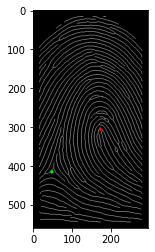

In [ ]:
def show_SP(img1,SP):
  res = cv.cvtColor(img1, cv.COLOR_GRAY2BGR)
  for l in SP['core']:
    cv.circle(res, (int(l[0]),int(l[1])), 2, (255,0,0), 3, cv.LINE_AA)

  for l in SP['delta']:
    cv.circle(res, (int(l[0]),int(l[1])), 2, (0,255,0), 3, cv.LINE_AA)
  plt.imshow(res)

In [ ]:
im = cv2.imread('102_7.tif',cv.IMREAD_GRAYSCALE) 
img1 = skeletonize(binarize(enhancer(im)))
minutiae_pts_arr = minutiae_generator(img1)
mask = filter_mask(im)
filtered_minutiae = list(filter(lambda m: mask[m[1], m[0]]>20, minutiae_pts_arr))
minutiae_angle = minutiae_angles(filtered_minutiae, img1)

SP = detectSP(im)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

# Ellipse Indexing

In [ ]:
u=[]
if len(SP['delta'])>0:
  u=SP['delta'][0]
else:
  u=SP['core'][0]
print(u)

[ 48. 415.]


In [ ]:
def getLen(a,b):
  return ((a[0]-b[0])**2+(a[1]-b[1])**2)**(0.5)

In [ ]:
print(minutiae_angle)
feature_vector = []
for i in range(len(minutiae_angle)):
  for j in range(i+1,len(minutiae_angle)):
    mi = [minutiae_angle[i][0],minutiae_angle[i][1]]
    mj = [minutiae_angle[j][0],minutiae_angle[j][1]]
    theta_i = minutiae_angle[i][3]
    theta_j = minutiae_angle[j][3]
    dij = getLen(mi,mj)
    dju = getLen(mj,u)
    diu = getLen(mi,u)
    if diu==0 or dju==0:
      continue
    A = diu + dju
    B = ((diu + dju)**2 - (dij)**2)**0.5
    cos_theta=(diu**2+dij**2-dju**2)/(2*diu*dij)
    if abs(cos_theta)>=1:
      continue
    theta = math.acos((diu**2+dij**2-dju**2)/(2*diu*dij))
    X = (mj[0]-mi[0])*math.cos(theta_i)+(mj[1]-mi[1])*math.sin(theta_i)
    Y = (mj[0]-mi[0])*math.sin(theta_i)-(mj[1]-mi[1])*math.cos(theta_i)
    alpha = math.atan(Y/X)
    beta = alpha + theta_j - theta_i
    feature_vector.append((A,B,theta,alpha,beta))

print(feature_vector)

[(67, 77, False, 0.6203213044253038), (62, 89, True, -2.459276098715045), (152, 107, True, -2.8842689386187046), (158, 119, True, -0.3217505543966422), (163, 135, True, -3.0419240010986313), (33, 138, True, -2.173083672929861), (236, 143, True, 2.459276098715045), (172, 144, False, -0.3024956301151815), (52, 148, False, 0.8831068249291878), (210, 150, True, 2.5829933382462307), (149, 179, False, -2.5708246005419797), (136, 201, True, 0.6435011087932844), (246, 227, False, 2.1016590459811533), (146, 229, False, 0.41707000735369), (163, 264, False, 0.05130964385248439), (190, 267, False, 2.8829489634259824), (166, 273, True, -2.427501954977635), (171, 274, True, -0.22679884805388587), (148, 278, True, 0.7853981633974483), (185, 278, False, -0.756020252039587), (56, 279, True, -1.941687615607559), (184, 279, False, -0.6938427547662063), (205, 282, False, 2.1058606277549767), (194, 287, False, 2.4183719874657257), (170, 294, False, -0.3011436730674821), (72, 301, True, -1.7782925532300993)